In [ ]:
 ###################
#https://github.com/fuenwang/Equirec2Perspec
##https://colab.research.google.com/github/xn2333/OpenCV/blob/master/Image_Processing_in_Python_Final.ipynb#scrollTo=6dy-iP-VTibt
##http://www.paul-reed.co.uk/programming.html

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import cv2 as cv 
from google.colab.patches import cv2_imshow # for image display
from skimage import io
from PIL import Image 
import matplotlib.pylab as plt
import cv2

In [ ]:
import numpy as np
from scipy.ndimage import map_coordinates
import matplotlib.pyplot as plt

def xyzcube(face_w):
    '''
    Return the xyz cordinates of the unit cube in [F R B L U D] format.
    '''
    global out
    out = np.zeros((face_w, face_w * 6, 3), np.float32)
    rng = np.linspace(-0.5, 0.5, num=face_w, dtype=np.float32)
    grid = np.stack(np.meshgrid(rng, -rng), -1)

    # Front face (z = 0.5)
    out[:, 0*face_w:1*face_w, [0, 1]] = grid
    out[:, 0*face_w:1*face_w, 2] = 0.5

    # Right face (x = 0.5)
    out[:, 1*face_w:2*face_w, [2, 1]] = grid
    out[:, 1*face_w:2*face_w, 0] = 0.5

    # Back face (z = -0.5)
    out[:, 2*face_w:3*face_w, [0, 1]] = grid
    out[:, 2*face_w:3*face_w, 2] = -0.5

    # Left face (x = -0.5)
    out[:, 3*face_w:4*face_w, [2, 1]] = grid
    out[:, 3*face_w:4*face_w, 0] = -0.5

    # Up face (y = 0.5)
    out[:, 4*face_w:5*face_w, [0, 2]] = grid
    out[:, 4*face_w:5*face_w, 1] = 0.5

    # Down face (y = -0.5)
    out[:, 5*face_w:6*face_w, [0, 2]] = grid
    out[:, 5*face_w:6*face_w, 1] = -0.5

    return out







def xyz2uv(xyz):
    '''
    xyz: ndarray in shape of [..., 3]
    '''
    x, y, z = np.split(xyz, 3, axis=-1)
    u = np.arctan2(x, z)
    c = np.sqrt(x**2 + z**2)
    v = np.arctan2(y, c)
    print('uv',np.concatenate([u, v], axis=-1))
    return np.concatenate([u, v], axis=-1)




#################################################################################################
def uv2coor(uv, h, w):
    '''
    uv: ndarray in shape of [..., 2]
    h: int, height of the equirectangular image
    w: int, width of the equirectangular image
    '''
    global coor_x
    global coor_y
    u, v = np.split(uv, 2, axis=-1)
    coor_x = (u / (2 * np.pi) + 0.5) * w - 0.5
    coor_y = (-v / np.pi + 0.5) * h - 0.5
    print('coor',np.concatenate([coor_x, coor_y], axis=-1))
    return np.concatenate([coor_x, coor_y], axis=-1)




def sample_equirec(e_img, coor_xy, order):
    global pad_u
    global pad_d
    #global e_img
    print("burari")
    print('e_img',e_img)
    print('e_shape',e_img.shape)
    print('starting image')
    cv2_imshow(e_img)
    plt.show()
    w = e_img.shape[1]
    print('w',w)
    coor_x, coor_y = np.split(coor_xy, 2, axis=-1)
    print('coor_x',coor_x.shape)
    print('coor_y',coor_y.shape)
    #pad_u = np.roll(e_img[[0]], w // 2, 1)
    #print('pad_u',pad_u.shape)
    #print("bye:",e_img.shape)
    
    #pad_d = np.roll(e_img[[-1]], w // 2, 1)
    #print('pad_d',e_img[[-1]].shape)
    #print("\npad_d")
    
    #e_img = np.concatenate([e_img, pad_d, pad_u], 0)
    print('e_img',e_img)
    print("Hello:",e_img.shape)
    #cv2_imshow(e_img)
    plt.show()

    print('coorshape',np.array([coor_y, coor_x]).shape)
    print('final',map_coordinates(e_img, [coor_y, coor_x],
                           order=order, mode='wrap')[..., 0])
    print('final.shape',map_coordinates(e_img, [coor_y, coor_x],
                           order=order, mode='wrap')[..., 0].shape)
    print("abc")
    cv2_imshow(map_coordinates(e_img, [coor_y, coor_x],
                           order=order, mode='wrap')[..., 0])
    plt.show()
    return map_coordinates(e_img, [coor_y, coor_x],
                           order=order, mode='wrap')[..., 0]




def cube_h2list(cube_h):
    assert cube_h.shape[0] * 6 == cube_h.shape[1]
    return np.split(cube_h, 6, axis=1)


def cube_list2h(cube_list):
    assert len(cube_list) == 6
    assert sum(face.shape == cube_list[0].shape for face in cube_list) == 6
    return np.concatenate(cube_list, axis=1)


def cube_h2dict(cube_h):
    cube_list = cube_h2list(cube_h)
    return dict([(k, cube_list[i])
                 for i, k in enumerate(['F', 'R', 'B', 'L', 'U', 'D'])])


def cube_dict2h(cube_dict, face_k=['F', 'R', 'B', 'L', 'U', 'D']):
    assert len(face_k) == 6
    return cube_list2h([cube_dict[k] for k in face_k])

##################################################################################################
def cube_h2dice(cube_h):
    assert cube_h.shape[0] * 6 == cube_h.shape[1]
    w = cube_h.shape[0]
    cube_dice = np.zeros((w * 3, w * 4, cube_h.shape[2]), dtype=cube_h.dtype)
    print('cube_dice.shape',cube_dice.shape)
    cube_list = cube_h2list(cube_h)
    #cv2_imshow(np.array(cube_list))
    #print('cube_list',cube_list)
    # Order: F R B L U D
    sxy = [(1, 1), (2, 1), (3, 1), (0, 1), (3, 0), (3, 2)]
    for i, (sx, sy) in enumerate(sxy):
        face = cube_list[i]
        if i in [1,2]:
            face = np.flip(face, axis=1)
        if i == 4:
            face = np.flip(face, axis=0)
        cube_dice[sy*w:(sy+1)*w, sx*w:(sx+1)*w] = face
    cv2_imshow(cube_dice)
    plt.show()
    return cube_dice





Equirectangular 2 cubemap

In [ ]:
import numpy as np



def e2c(e_img, face_w=256, mode='bilinear', cube_format='dice'):
    '''
    e_img:  ndarray in shape of [H, W, *]
    face_w: int, the length of each face of the cubemap

    '''


    cv2_imshow(e_img)
    plt.show()
    print(e_img.shape)
    assert len(e_img.shape) == 3
    h, w = e_img.shape[:2]
    if mode == 'bilinear':
        order = 1
    elif mode == 'nearest':
        order = 0
    else:
        raise NotImplementedError('unknown mode')

    xyz = xyzcube(face_w)
    uv = xyz2uv(xyz)
    coor_xy = uv2coor(uv, h, w)

    cubemap = np.stack([
        sample_equirec(e_img[..., i], coor_xy, order=order)
        for i in range(e_img.shape[2])
    ], axis=-1)

    
    print('shapecubemap',cubemap.shape)
    cv2_imshow(cubemap)
    plt.show()

    if cube_format == 'horizon':
        pass
    elif cube_format == 'list':
        cubemap =cube_h2list(cubemap)
    elif cube_format == 'dict':
        cubemap = cube_h2dict(cubemap)
    elif cube_format == 'dice':
        cubemap =cube_h2dice(cubemap)
    else:
        raise NotImplementedError()
    print('cubemap',cubemap)
    print('cube.shape',cubemap.shape)
    return cubemap

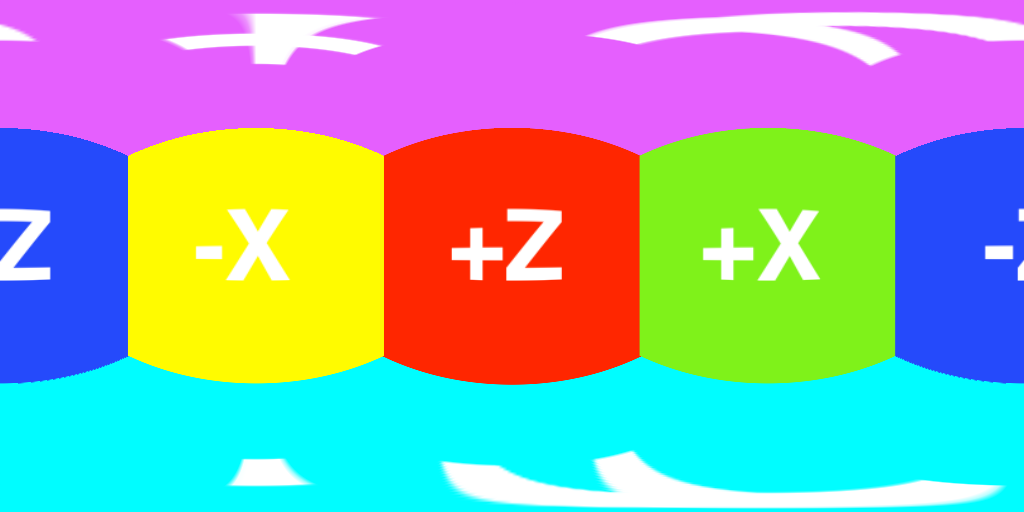

In [ ]:
import cv2

# Save image in set directory
# Read RGB image
img = cv2.imread('/content/drive/MyDrive/PhD_P21EE005/Images/demo_equirec.png')
#cv2_imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
cv2_imshow(img)


In [ ]:
print(type(img))

<class 'numpy.ndarray'>


In [ ]:
img.shape

(512, 1024, 3)

In [ ]:
img[...,2]

array([[229, 229, 229, ..., 229, 229, 229],
       [229, 229, 229, ..., 229, 229, 229],
       [229, 229, 229, ..., 229, 229, 229],
       ...,
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0]], dtype=uint8)

In [ ]:
cube=e2c(img, face_w=256, mode='bilinear', cube_format='dice')

NameError: ignored

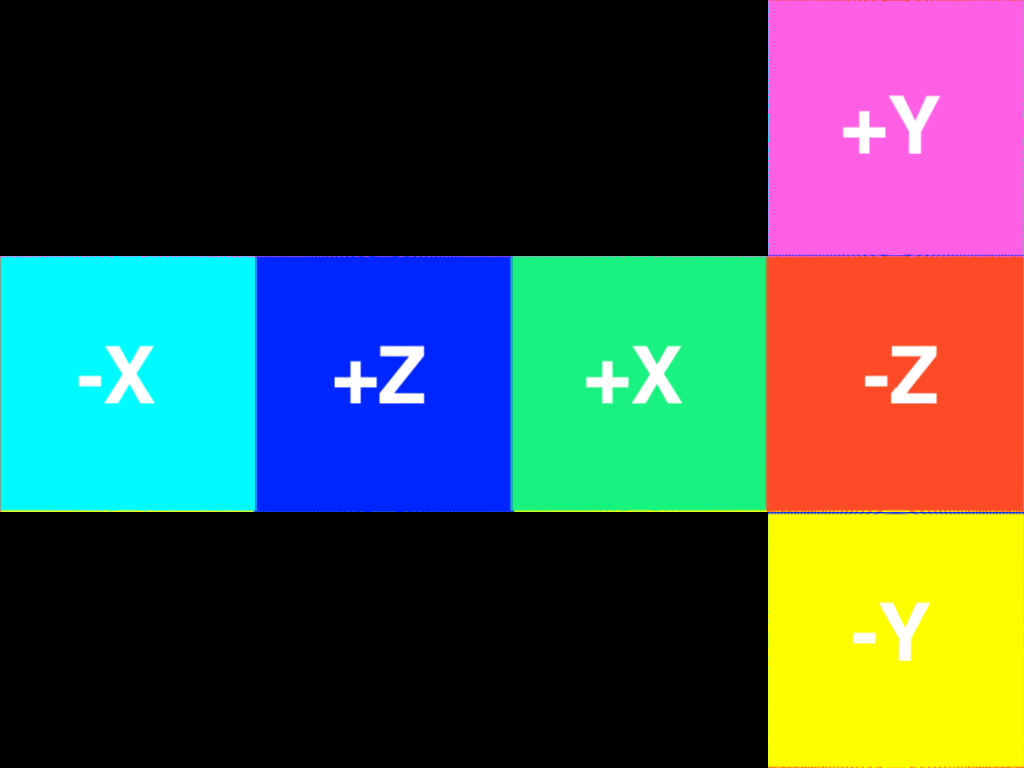

In [ ]:
cv2_imshow(cv.cvtColor(cube, cv.COLOR_BGR2RGB))

In [ ]:
coor_x.shape

(256, 1536, 1)

In [ ]:
coor_x[0][1280:]

In [ ]:
coor_x

In [ ]:
out

In [ ]:
from scipy.ndimage.interpolation import map_coordinates
import numpy as np


in_data = np.array([[0., -1., 2.],
                    [2., 1., 0.],
                    [4., 3., 2.]])  # z = 2.*x - 1.*y

# want the second argument as a column vector (or a transposed row)
# see on some points of the grid:
print('at the point 0, 0 of the grid the function z is: ')
print(map_coordinates(in_data, np.array([[0., 0.]]).T, order=1))
print('at the point 0, 1 of the grid the function z is: ')
print(map_coordinates(in_data, np.array([[0., 1.]]).T, order=1))
print('at the point 0, 2 of the grid the function z is: ')
print(map_coordinates(in_data, np.array([[0., 2.]]).T, order=1))

# see some points outside the grid
print()
print('at the point 0.2, 0.2 of the grid, with linear interpolation z is:')
print(map_coordinates(in_data, np.array([[.2, .2]]).T, order=1))
print('and it coincides with 2.*.2 - .2')
print()
print('at the point 0.2, 0.2 of the grid, with cubic interpolation z is:')
#print(map_coordinates(in_data, np.array([[0.2, .2]]).T, order=3)

In [ ]:
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import numpy as np

### 1d example of interpolation ###

in_data_x = np.array([1., 2., 3., 4., 5., 6.])
in_data_y = np.array([1.5, 2., 2.5, 3.,  3.5,  4.])  # y = .5 x - 1
f = interp1d(in_data_x, in_data_y, kind='linear')

print(f)
# f in all of the points of the grid (in_data_x): output coincides with in_data_y

    
print(f(1), f(1.), f(1.5), f(2.), f(2.5), f(3.))
# f in a point outside the grid:
print(f(1.8))
# this is equal to y = .5 x - 1 for x = 1.8, up to some point.
#assert round(0.5 * 1.8 + 1, ndigits=10) == round(f(1.8), ndigits=10)

# plot up to this point
xnew = np.arange(1, 6, 0.1)
ynew = f(xnew)
plt.plot(in_data_x, in_data_y, 'o', xnew, ynew, '-')
# close the image to move forward.
plt.show()

In [ ]:
s

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import PIL

In [ ]:
from PIL import Image	# Python Imaging Library
import math				# Maths functions
import sys				# Allows us to access function args
import os				# Allows us to split the text for saving the file
#print(str(sys.argv))
image = Image.open(r'/content/drive/MyDrive/PhD_P21EE005/Images/equirect.JPG')
inputWidth, inputHeight = image.size;

print(image.size)
sqr = inputWidth/4.0

outputWidth = sqr*3

outputHeight = sqr*2

output = []

def getTheta(x,y):
	rtn = 0
	if(y<0):
		rtn =  math.atan2(y,x)*-1
	else:
		rtn = math.pi+(math.pi-math.atan2(y,x))
	return rtn






for loopY in range(1,int(outputHeight+1)):		# 1..height inclusive

	for loopX in range(1,int(outputWidth+1)):	# 1..width inclusive
		
		print(str(loopY)+", "+str(loopX))
	  
		tx = 0
		ty = 0
		x = 0;
		y = 0;
		z = 0;
	
		if(loopY<sqr+1): # top half

		
			if(loopX<sqr+1): 		# top left box [Y+]
				
				tx = loopX
				
				ty = loopY
				
				x = tx-0.5*sqr
				
				y = 0.5*sqr
				
				z = ty-0.5*sqr
			  
				print('tx',tx)
		
				print('ty',ty)
		
				
				print('x',x)
				print('y',y)
				print('z',z)
			
			elif(loopX<2*sqr+1):	# top middle [X+]
			
				tx = loopX-sqr
				ty = loopY
				x = 0.5*sqr
				y = (tx-0.5*sqr)*-1
				z = ty-0.5*sqr
				print('tx',tx)
				print('ty',ty)
				
				print('x',x)
				print('y',y)
				print('z',z)
			
			else:					# top right [Y-]
			
				tx = loopX-sqr*2
				ty = loopY
				x = (tx-0.5*sqr)*-1
				y = -0.5*sqr
				z = ty-0.5*sqr
				print('tx',tx)
				print('ty',ty)
				
				print('x',x)
				print('y',y)
				print('z',z)
			
		else:	# bottom half
		
			if(loopX<sqr+1): 		# bottom left box [X-]
			
				tx = loopX
				ty = loopY - sqr
				x = int(-0.5*sqr)
				y = int(tx-0.5*sqr)
				z = int(ty-0.5*sqr)
				print('tx',tx)
				print('ty',ty)
				
				print('x',x)
				print('y',y)
				print('z',z)
				
				#print(str(x)+", "+str(y)+", "+str(z))
			
			elif(loopX<2*sqr+1):	# bottom middle [Z-]
			
				tx = loopX-sqr
				ty = loopY-sqr
				x = (ty-0.5*sqr)*-1
				y = (tx-0.5*sqr)*-1
				z = 0.5*sqr	
				print('tx',tx)
				print('ty',ty)
				
				print('x',x)
				print('y',y)
				print('z',z)		# was -0.5 might be due to phi being reversed
			
			else:					# bottom right [Z+]

				tx = loopX-sqr*2
				ty = loopY - sqr
				x = ty-0.5*sqr
				y = (tx-0.5*sqr)*-1
				z = -0.5*sqr
				print('tx',tx)
				print('ty',ty)
				
				print('x',x)
				print('y',y)
				print('z',z) 		# was +0.5 might be due to phi being reversed
					
		# now find out the polar coordinates
		
		rho = math.sqrt(x*x+y*y+z*z)
		normTheta = getTheta(x,y)/(2*math.pi)			# /(2*math.pi) normalise theta
		normPhi = (math.pi-math.acos(z/rho))/math.pi	# /math.pi normalise phi

		print('rho',rho)
		print('normTheta',normTheta)
		print('normPhi',normPhi)
		
		# use this for coordinates 
		
		iX = normTheta*inputWidth
		iY = normPhi*inputHeight

		print('iX',iX)
		print('iY',iY)
	

		# catch possible overflows
		
		if(iX>=inputWidth):
			iX=iX-(inputWidth)
		if(iY>=inputHeight):
			iY=iY-(inputHeight)
			
		output.append(image.getpixel((int(iX),int(iY))))
		
outputImage = Image.new("RGB",((int(outputWidth)),(int(outputHeight))), None)
outputImage.putdata(output)


outputImage.save(os.path.splitext(sys.argv[1])[0]+"_CUBE.png")

Streaming output truncated to the last 5000 lines.
z -71.875
rho 111.7275564710873
normTheta 0.09622833322447
normPhi 0.27756234062778684
iX 55.33129160407025
iY 79.93795410080261
286, 409
tx 121.5
ty 142.25
x 70.375
y -49.625
z -71.875
rho 112.16638032405254
normTheta 0.09774892934432616
normPhi 0.2786072780280675
iX 56.20563437298755
iY 80.23889607208343
286, 410
tx 122.5
ty 142.25
x 70.375
y -50.625
z -71.875
rho 112.61237443105442
normTheta 0.09924930951529305
normPhi 0.2796580538300312
iX 57.06835297129351
iY 80.54151950304897
286, 411
tx 123.5
ty 142.25
x 70.375
y -51.625
z -71.875
rho 113.06545394151124
normTheta 0.10072961282467006
normPhi 0.28071413313552107
iX 57.919527374185286
iY 80.84567034303006
286, 412
tx 124.5
ty 142.25
x 70.375
y -52.625
z -71.875
rho 113.52553402208686
normTheta 0.1021899885576102
normPhi 0.2817749950354964
iX 58.759243420625864
iY 81.15119857022296
286, 413
tx 125.5
ty 142.25
x 70.375
y -53.625
z -71.875
rho 113.99252990876201
normTheta 0.1036305954

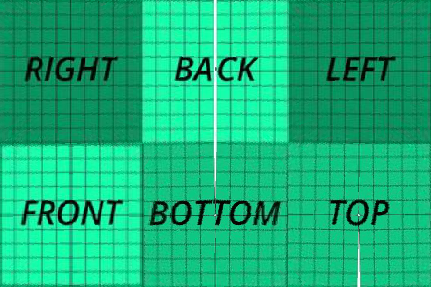

In [ ]:
outputImage

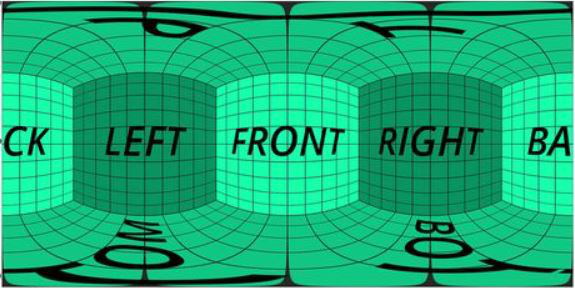

In [ ]:
image

In [ ]:
len(output)

123697

In [ ]:
import numpy as np
import pandas as pd
import cv2 as cv 
from google.colab.patches import cv2_imshow # for image display
from skimage import io
from PIL import Image 
import matplotlib.pylab as plt
import cv2

In [ ]:
import cv2

# Save image in set directory
# Read RGB image
##img = cv2.imread('/content/drive/MyDrive/PhD_P21EE005/Images/demo_equirec.png')
#cv2_imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
#cv2_imshow(outputImage)


AttributeError: ignored

In [ ]:
# import modules
import cv2
import numpy as np
import math
import sys
import time


# Interpolation kernel
def u(s, a):
	if (abs(s) >= 0) & (abs(s) <= 1):
		return (a+2)*(abs(s)**3)-(a+3)*(abs(s)**2)+1
	elif (abs(s) > 1) & (abs(s) <= 2):
		return a*(abs(s)**3)-(5*a)*(abs(s)**2)+(8*a)*abs(s)-4*a
	return 0


# Padding
def padding(img, H, W, C):
	zimg = np.zeros((H+4, W+4, C))
	zimg[2:H+2, 2:W+2, :C] = img
	
	# Pad the first/last two col and row
	zimg[2:H+2, 0:2, :C] = img[:, 0:1, :C]
	zimg[H+2:H+4, 2:W+2, :] = img[H-1:H, :, :]
	zimg[2:H+2, W+2:W+4, :] = img[:, W-1:W, :]
	zimg[0:2, 2:W+2, :C] = img[0:1, :, :C]
  # Pad the missing eight points
	zimg[0:2, 0:2, :C] = img[0, 0, :C]
	zimg[H+2:H+4, 0:2, :C] = img[H-1, 0, :C]
	zimg[H+2:H+4, W+2:W+4, :C] = img[H-1, W-1, :C]
	zimg[0:2, W+2:W+4, :C] = img[0, W-1, :C]
	return zimg


# Bicubic operation
def bicubic(img, ratio, a):
	
	# Get image size
	H, W, C = img.shape
	
	# Here H = Height, W = weight,
	# C = Number of channels if the
	# image is coloured.
	img = padding(img, H, W, C)
	
	# Create new image
	dH = math.floor(H*ratio)
	dW = math.floor(W*ratio)

	# Converting into matrix
	dst = np.zeros((dH, dW, 3))
	# np.zeroes generates a matrix
	# consisting only of zeroes
	# Here we initialize our answer
	# (dst) as zero

	h = 1/ratio

	print('Start bicubic interpolation')
	print('It will take a little while...')
	inc = 0
	
	for c in range(C):
		for j in range(dH):
			for i in range(dW):
				
				# Getting the coordinates of the
				# nearby values
				x, y = i * h + 2, j * h + 2

				x1 = 1 + x - math.floor(x)
				x2 = x - math.floor(x)
				x3 = math.floor(x) + 1 - x
				x4 = math.floor(x) + 2 - x

				y1 = 1 + y - math.floor(y)
				y2 = y - math.floor(y)
				y3 = math.floor(y) + 1 - y
				y4 = math.floor(y) + 2 - y
				
				# Considering all nearby 16 values
				mat_l = np.matrix([[u(x1, a), u(x2, a), u(x3, a), u(x4, a)]])
				mat_m = np.matrix([[img[int(y-y1), int(x-x1), c],
									img[int(y-y2), int(x-x1), c],
									img[int(y+y3), int(x-x1), c],
									img[int(y+y4), int(x-x1), c]],
								[img[int(y-y1), int(x-x2), c],
									img[int(y-y2), int(x-x2), c],
									img[int(y+y3), int(x-x2), c],
									img[int(y+y4), int(x-x2), c]],
								[img[int(y-y1), int(x+x3), c],
									img[int(y-y2), int(x+x3), c],
									img[int(y+y3), int(x+x3), c],
									img[int(y+y4), int(x+x3), c]],
								[img[int(y-y1), int(x+x4), c],
									img[int(y-y2), int(x+x4), c],
									img[int(y+y3), int(x+x4), c],
									img[int(y+y4), int(x+x4), c]]])
				mat_r = np.matrix(
					[[u(y1, a)], [u(y2, a)], [u(y3, a)], [u(y4, a)]])
				
				# Here the dot function is used to get
				# the dot product of 2 matrices
				dst[j, i, c] = np.dot(np.dot(mat_l, mat_m), mat_r)

	# If there is an error message, it
	# directly goes to stderr
	sys.stderr.write('\n')
	
	# Flushing the buffer
	sys.stderr.flush()
	return dst


# Read image
# You can put your input image over
# here to run bicubic interpolation
# The read function of Open CV is used
# for this task
img = cv2.imread('/content/drive/MyDrive/PhD_P21EE005/Images/demo_equirec.png')

# Scale factor
ratio = 2
# Coefficient
a = -1/2

# Passing the input image in the
# bicubic function
dst = bicubic(img, ratio, a)
print('Completed!')

# Saving the output image
cv2.imwrite('bicubic.png', dst)
bicubicImg = cv2.imread('bicubic.png')

# display shapes of both images
print('Original Image Shape:', img.shape)
print('Generated Bicubic Image Shape:', bicubicImg.shape)


Start bicubic interpolation
It will take a little while...


Completed!
Original Image Shape: (512, 1024, 3)
Generated Bicubic Image Shape: (1024, 2048, 3)


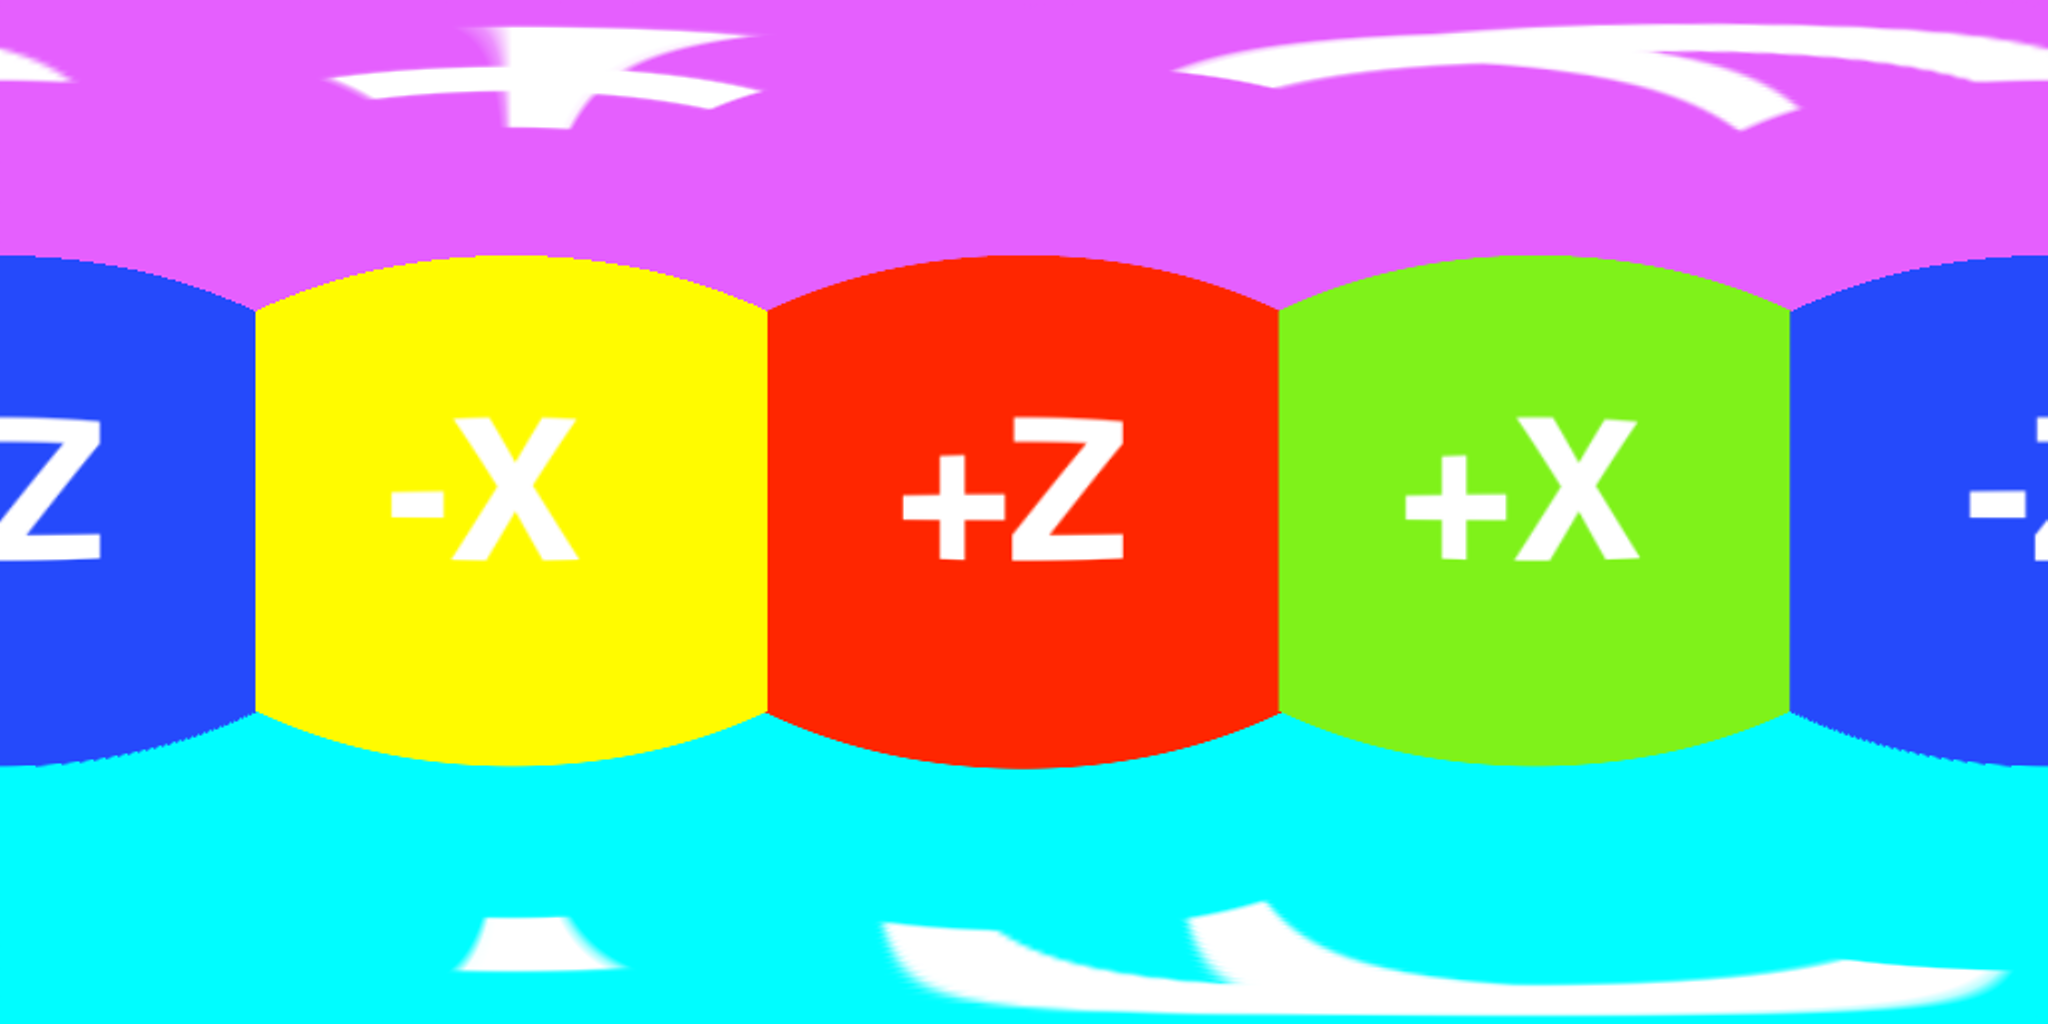

In [ ]:
cv2_imshow(bicubicImg)

In [ ]:
######################################################################################################3

In [ ]:
#############################################

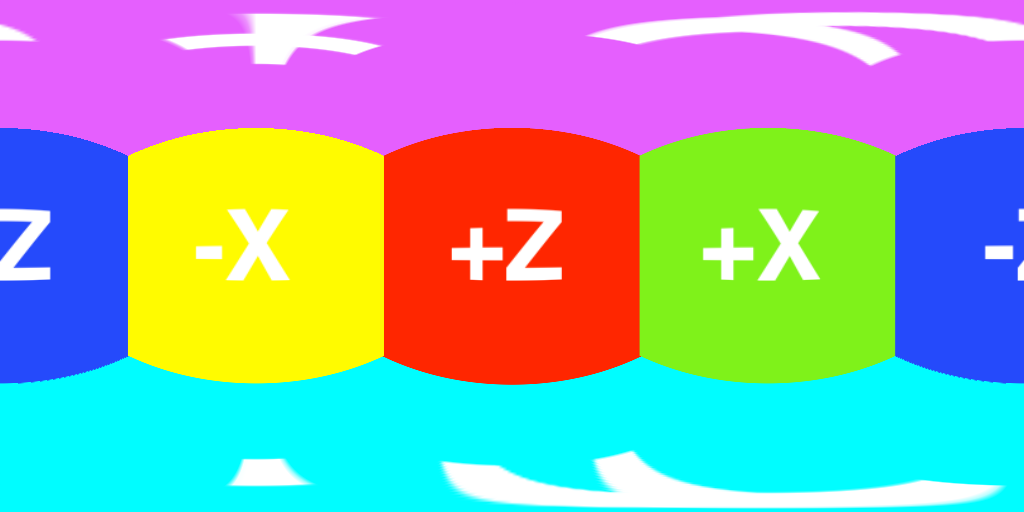

In [ ]:
import cv2

# Save image in set directory
# Read RGB image
img = cv2.imread('/content/drive/MyDrive/PhD_P21EE005/Images/demo_equirec.png')
#cv2_imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
cv2_imshow(img)

In [ ]:
img_=list(img)

In [ ]:
np.array(img_).shape

(512, 1024, 3)

In [ ]:
len(img_)

512

In [ ]:
im=[]
for i in range(len(img_)):
  im.append(img_[i][::2])
    
    

In [ ]:
np.array(im).shape

(512, 512, 3)

In [ ]:
im_=np.array(im)

In [ ]:
im_.shape

(512, 512, 3)

In [ ]:
im_[0]

array([[254,  95, 229],
       [254,  95, 229],
       [254,  95, 229],
       ...,
       [254,  95, 229],
       [254,  95, 229],
       [254,  95, 229]], dtype=uint8)

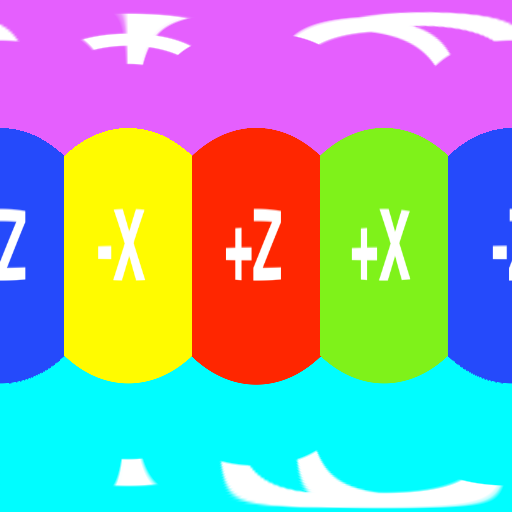

In [ ]:
cv2_imshow(im_)

In [ ]:
img_[100][2:5]

array([[254,  95, 229],
       [254,  95, 229],
       [254,  95, 229]], dtype=uint8)

In [ ]:
type(img_)

list

In [ ]:
from statistics import mean

In [ ]:
type(img_)

list

In [ ]:
from statistics import mean


sampled=[[] for i in range(len(img_))]

for i in range(len(img_)):
  
  a=0
  b=10
  avg_=[]
  while(b<=1024):
    m=[]
    m.append((img_[i][a:b]))
    avg=[]
    #print(m)
    #print(m[0])

    for j in range(len(m)):
      avg.append(mean(m[0][j]))
    #print('avg',avg)
    avg_.append((mean(avg)))
    print('avg_',avg_)
    print('len{avg}',len(avg))
    a=b
    b=b+10
  num=[]
  for k in range(1,len(avg_)-1):
     if avg_[k+1] < avg_[k] > avg_[k-1] or avg_[k+1] > avg_[k] < avg_[k-1] or avg_[k+1] < avg_[k] < avg_[k-1]or avg_[k+1] > avg_[k] > avg_[k-1]  :
       num.append(k)
  print('num',num)
  for z in num:
    sampled[i].append(img_[i][10*z:10*(z+1)])
  print(sampled[i])
     





  










Streaming output truncated to the last 5000 lines.
avg_ [169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 174, 227, 249, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255]
len{avg} 1
avg_ [169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 174, 227, 249, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255]
len{avg} 1
avg_ [169, 169, 169,

In [ ]:
sampled

[[], [], [], [], [], [], [], [], [], [], [], [array([[254, 105, 230],
         [254, 106, 230],
         [254, 107, 230],
         [254, 108, 230],
         [254, 108, 231],
         [254, 109, 231],
         [254, 109, 231],
         [254, 109, 231],
         [254, 110, 231],
         [254, 109, 231]], dtype=uint8), array([[254, 109, 231],
         [254, 109, 231],
         [254, 108, 231],
         [254, 108, 230],
         [254, 107, 230],
         [254, 106, 230],
         [254, 106, 230],
         [254, 105, 230],
         [254, 104, 230],
         [254, 104, 230]], dtype=uint8), array([[254, 103, 230],
         [254, 102, 230],
         [254, 101, 230],
         [254, 102, 230],
         [254, 103, 230],
         [254, 103, 230],
         [254, 104, 230],
         [254, 105, 230],
         [254, 105, 230],
         [254, 106, 230]], dtype=uint8), array([[254, 106, 230],
         [254, 106, 230],
         [254, 107, 230],
         [254, 107, 230],
         [254, 107, 231],
       

In [ ]:
final=[]
for i in range(len(sampled)):
  if sampled[i]!=[]:
    final.append(sampled[i])
  

In [ ]:
y=[]
for i in range(len(final)):
  y.append(len(final[i]))
print(max(y))

31


In [ ]:
from scipy import interpolate

def f(x):
    x_points = [ 0, 1, 2, 3, 4, 5]
    y_points = [12,14,22,39,58,77]

    tck = interpolate.splrep(x_points, y_points)
    return interpolate.splev(x, tck)

print(f(10))

172.0


In [ ]:
import numpy as np
from scipy import interpolate

x = np.arange(0,10)
y = np.exp(-x/3.0)
f = interpolate.interp1d(x, y, fill_value='extrapolate')

print(f(9))


0.049787068367863944


[array([[255, 253,   6],
        [255, 253,   7],
        [255, 253,   7],
        [255, 253,   8],
        [255, 253,   9],
        [255, 253,   9],
        [255, 253,  10],
        [255, 253,  11],
        [255, 253,  11],
        [255, 253,  12]], dtype=uint8), array([[255, 253,  12],
        [255, 253,  13],
        [255, 253,  13],
        [255, 253,  14],
        [255, 253,  14],
        [255, 253,  15],
        [255, 253,  15],
        [255, 253,  16],
        [255, 253,  16],
        [255, 253,  17]], dtype=uint8), array([[255, 253,  17],
        [255, 253,  18],
        [255, 253,  18],
        [255, 253,  19],
        [255, 253,  19],
        [255, 253,  19],
        [255, 253,  20],
        [255, 253,  20],
        [255, 253,  20],
        [255, 253,  21]], dtype=uint8), array([[255, 253,  21],
        [255, 253,  21],
        [255, 253,  22],
        [255, 253,  22],
        [255, 253,  22],
        [255, 253,  22],
        [255, 253,  23],
        [255, 253,  23],
        

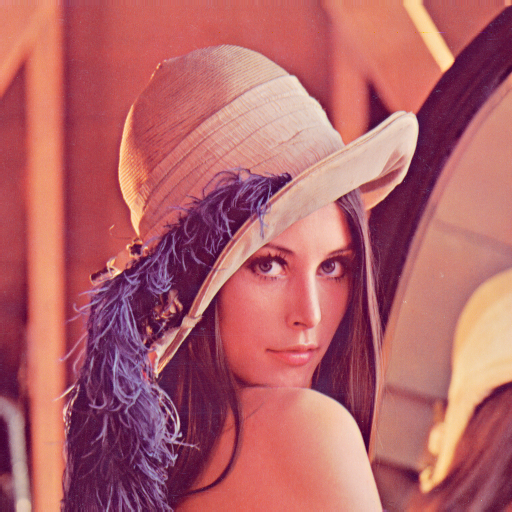

In [ ]:
import cv2

# Save image in set directory
# Read RGB image
img = cv2.imread('/content/drive/MyDrive/lena.png')
#cv2_imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
cv2_imshow(img)

In [ ]:
img_=list(img)

In [ ]:
im=[]
for i in range(len(img_)):
  im.append(img_[i][::2])
    

In [ ]:
im_=np.array(im)

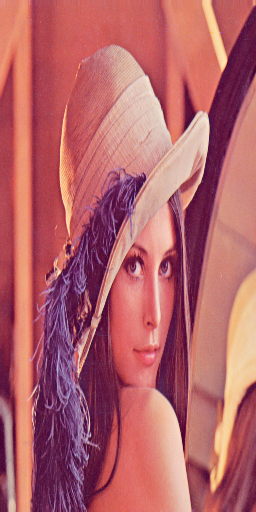

In [ ]:
cv2_imshow(im_)

In [ ]:



###########################################################################################################################
############################################################################################################################

In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt



In [ ]:
import cv2

# Save image in set directory
# Read RGB image
img = cv2.imread('/content/drive/MyDrive/PhD_P21EE005/Images/demo_equirec.png')


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


(Text(0.5, 1.0, 'Input Image'),
 ([], <a list of 0 Text major ticklabel objects>),
 ([], <a list of 0 Text major ticklabel objects>))

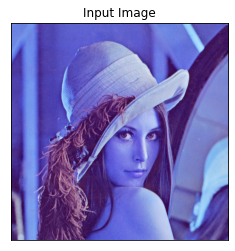

In [ ]:
#img = cv2.imread('messi5.jpg',0)
f = np.fft.fft2(img)
fshift = np.fft.fftshift(f)
magnitude_spectrum = 20*np.log(np.abs(fshift))

plt.plot(),plt.imshow(img, cmap = 'gray')
plt.title('Input Image'), plt.xticks([]), plt.yticks([])


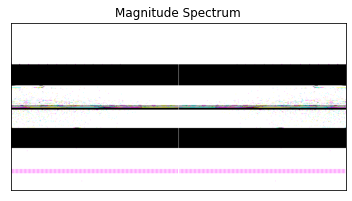

In [ ]:
plt.plot(),plt.imshow(magnitude_spectrum, cmap = 'gray')
plt.title('Magnitude Spectrum'), plt.xticks([]), plt.yticks([])
plt.show()

In [ ]:
gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

In [ ]:
rows, cols = gray_image.shape
crow,ccol = rows/2 , cols/2
fshift[crow-30:crow+30, ccol-30:ccol+30] = 0
f_ishift = np.fft.ifftshift(fshift)
img_back = np.fft.ifft2(f_ishift)
img_back = np.abs(img_back)

plt.subplot(131),plt.imshow(img, cmap = 'gray')
plt.title('Input Image'), plt.xticks([]), plt.yticks([])
plt.subplot(132),plt.imshow(img_back, cmap = 'gray')
plt.title('Image after HPF'), plt.xticks([]), plt.yticks([])
plt.subplot(133),plt.imshow(img_back)
plt.title('Result in JET'), plt.xticks([]), plt.yticks([])

plt.show()

TypeError: ignored

In [ ]:
#############################################################################################################################
#############################################################################################################################

In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

In [ ]:
import numpy as np
import pandas as pd
import cv2 as cv 
from google.colab.patches import cv2_imshow # for image display
from skimage import io
from PIL import Image 
import matplotlib.pylab as plt
import cv2

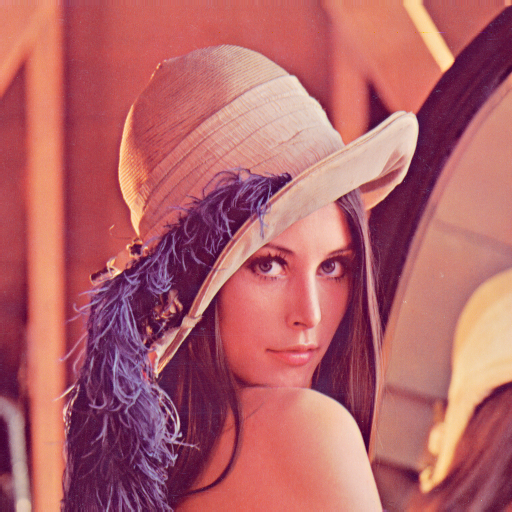

In [ ]:
import cv2

# Save image in set directory
# Read RGB image
img = cv2.imread('/content/drive/MyDrive/lena.png')
#cv2_imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
cv2_imshow(img)

In [ ]:
img

array([[[125, 137, 226],
        [125, 137, 226],
        [133, 137, 223],
        ...,
        [122, 148, 230],
        [110, 130, 221],
        [ 90,  99, 200]],

       [[125, 137, 226],
        [125, 137, 226],
        [133, 137, 223],
        ...,
        [122, 148, 230],
        [110, 130, 221],
        [ 90,  99, 200]],

       [[125, 137, 226],
        [125, 137, 226],
        [133, 137, 223],
        ...,
        [122, 148, 230],
        [110, 130, 221],
        [ 90,  99, 200]],

       ...,

       [[ 60,  18,  84],
        [ 60,  18,  84],
        [ 58,  27,  92],
        ...,
        [ 84,  73, 173],
        [ 76,  68, 172],
        [ 79,  62, 177]],

       [[ 57,  22,  82],
        [ 57,  22,  82],
        [ 62,  32,  96],
        ...,
        [ 79,  70, 179],
        [ 81,  71, 181],
        [ 81,  74, 185]],

       [[ 57,  22,  82],
        [ 57,  22,  82],
        [ 62,  32,  96],
        ...,
        [ 79,  70, 179],
        [ 81,  71, 181],
        [ 81,  74, 185]]

In [ ]:
img.shape

(512, 512, 3)

Grayscale Pixel Values as Features

In [ ]:
gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
 


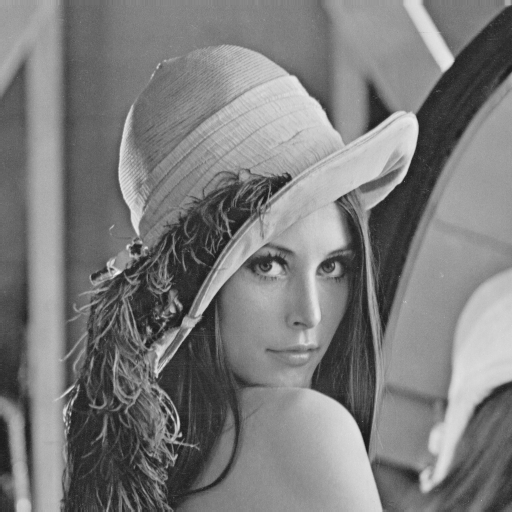

In [ ]:
cv2_imshow(gray_image)

In [ ]:
gray_image

array([[162, 162, 162, ..., 170, 155, 128],
       [162, 162, 162, ..., 170, 155, 128],
       [162, 162, 162, ..., 170, 155, 128],
       ...,
       [ 43,  43,  50, ..., 104, 100,  98],
       [ 44,  44,  55, ..., 104, 105, 108],
       [ 44,  44,  55, ..., 104, 105, 108]], dtype=uint8)

In [ ]:
gray=list(gray_image)

In [ ]:
a=[]
for i in range(len(gray)):
  for j in gray[i]:
    a.append(j)


In [ ]:
a

[162,
 162,
 162,
 161,
 162,
 157,
 163,
 161,
 165,
 161,
 162,
 160,
 155,
 163,
 160,
 155,
 157,
 156,
 161,
 161,
 154,
 156,
 154,
 157,
 155,
 157,
 155,
 152,
 156,
 154,
 154,
 156,
 154,
 158,
 155,
 160,
 158,
 167,
 160,
 166,
 166,
 165,
 166,
 172,
 171,
 175,
 173,
 170,
 172,
 172,
 167,
 175,
 168,
 167,
 162,
 161,
 148,
 148,
 155,
 141,
 130,
 119,
 118,
 106,
 97,
 97,
 94,
 92,
 88,
 97,
 103,
 96,
 103,
 100,
 104,
 105,
 105,
 105,
 104,
 110,
 110,
 108,
 107,
 105,
 104,
 109,
 109,
 109,
 108,
 107,
 107,
 108,
 110,
 109,
 107,
 109,
 109,
 110,
 110,
 108,
 104,
 106,
 106,
 108,
 109,
 111,
 117,
 110,
 113,
 118,
 121,
 119,
 112,
 122,
 121,
 122,
 125,
 122,
 121,
 124,
 124,
 130,
 129,
 123,
 122,
 127,
 132,
 131,
 132,
 129,
 135,
 129,
 128,
 131,
 131,
 127,
 135,
 136,
 132,
 134,
 131,
 131,
 128,
 130,
 134,
 126,
 129,
 126,
 133,
 130,
 129,
 131,
 128,
 132,
 129,
 128,
 135,
 133,
 136,
 134,
 128,
 134,
 130,
 135,
 133,
 133,
 134,
 135,

Mean Pixel Value of Channels

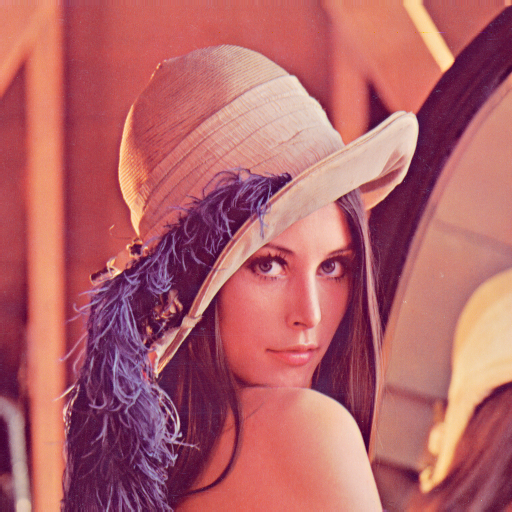

In [ ]:
cv2_imshow(img)

In [ ]:
img.shape

(512, 512, 3)

In [ ]:
img_=list(img)

In [ ]:
from statistics import mean
x=[]
for i in range(len(img_[0])):
  for k in range(len(img_[1])):
    x.append(mean(img_[i][k]))



In [ ]:
x

[162,
 162,
 164,
 162,
 161,
 157,
 163,
 161,
 164,
 160,
 163,
 160,
 153,
 161,
 159,
 154,
 154,
 155,
 160,
 158,
 153,
 153,
 151,
 154,
 153,
 155,
 153,
 149,
 157,
 153,
 156,
 154,
 151,
 155,
 153,
 160,
 156,
 165,
 156,
 165,
 163,
 162,
 163,
 168,
 167,
 171,
 169,
 167,
 168,
 167,
 165,
 170,
 165,
 165,
 160,
 161,
 147,
 148,
 157,
 144,
 134,
 125,
 123,
 113,
 105,
 105,
 103,
 103,
 96,
 107,
 110,
 103,
 109,
 107,
 111,
 111,
 113,
 111,
 111,
 117,
 115,
 113,
 113,
 111,
 110,
 114,
 115,
 115,
 113,
 114,
 113,
 113,
 116,
 114,
 112,
 115,
 115,
 114,
 116,
 113,
 109,
 111,
 111,
 113,
 113,
 116,
 121,
 116,
 118,
 122,
 125,
 122,
 117,
 127,
 124,
 124,
 128,
 124,
 126,
 126,
 128,
 132,
 132,
 126,
 126,
 130,
 134,
 133,
 134,
 132,
 138,
 132,
 131,
 135,
 134,
 130,
 139,
 137,
 135,
 137,
 133,
 134,
 131,
 132,
 137,
 129,
 132,
 129,
 135,
 132,
 131,
 132,
 129,
 136,
 131,
 131,
 137,
 134,
 140,
 136,
 130,
 137,
 133,
 137,
 134,
 136,
 137,

In [ ]:
import numpy as np
from skimage.io import imread, imshow
from skimage.filters import prewitt_h,prewitt_v
import matplotlib.pyplot as plt

In [ ]:
edges_prewitt_horizontal = prewitt_h(gray_image)
#calculating vertical edges using prewitt kernel
edges_prewitt_vertical = prewitt_v(gray_image)

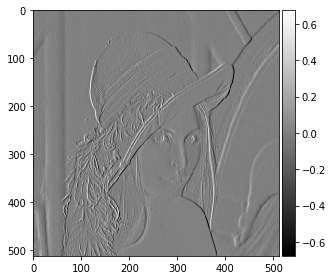

In [ ]:


imshow(edges_prewitt_vertical, cmap='gray')

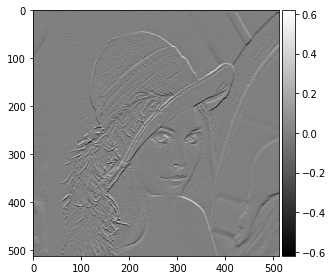

In [ ]:
imshow(edges_prewitt_horizontal, cmap='gray')